In [1]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import math

from pathlib import Path
from collections import defaultdict

In [2]:
image_group = 9

In [3]:
PATH_PROJECT = Path('/home/team/sasha/data/experimental/image_retrieval/')
# path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
paths = [path_tmpl % (image_group, i) for i in range(1,6)]
imgs = [cv.imread(path) for path in paths]

In [4]:
# path_labels = PATH_PROJECT / '.data/imat2011/learning.txt'
path_labels = 'learning.txt'

def get_labels(path_lables):
    
    with open(path_lables, 'r', newline='\n') as fin:
        learning = [line.strip() for line in fin]
    
    learning_dict = defaultdict(set)
    for l in learning:
        g, i = l.split('.')[0].split('_')
        learning_dict[int(g)].add(int(i))
    
    return learning_dict

In [5]:
learning_dict = get_labels(path_labels)

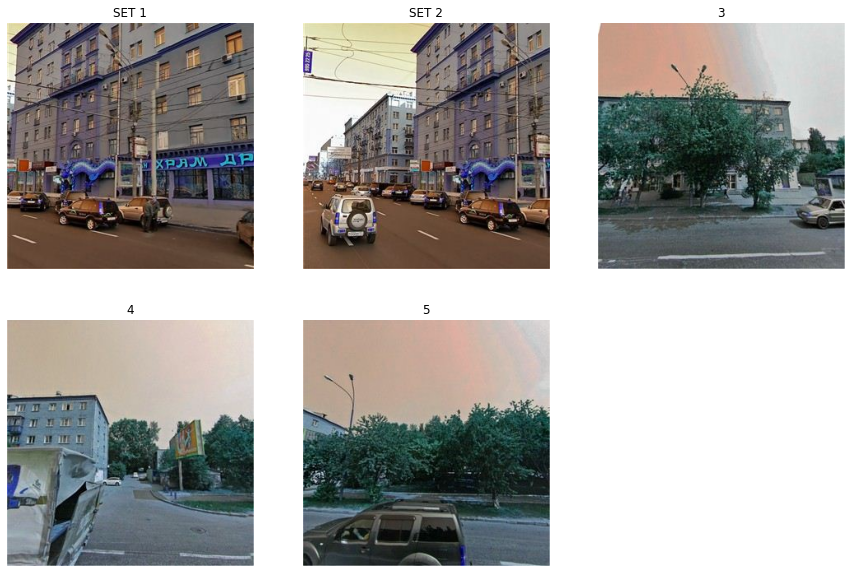

In [6]:
plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs, 1):
    ax = plt.subplot(2, 3, i)
    plt.imshow(img)
    if i in learning_dict[image_group]:
        plt.title("SET %d" % i)
    else:
        plt.title("%d" % i)
    plt.axis("off")

In [12]:
minHessian = 400
img1, img2 = imgs[0], imgs[1]
surf = cv.xfeatures2d_SURF.create()
kps1, dscr1 = surf.detectAndCompute(img1, None)
kps2, dscr2 = surf.detectAndCompute(img2, None)
dscr1[0]

array([-2.6510333e-04, -2.5426864e-03,  3.2522937e-03,  6.4571556e-03,
       -4.9091531e-03, -1.5546421e-02,  9.4576664e-03,  5.3291164e-02,
        9.4193425e-03, -3.6229506e-02,  2.5944971e-02,  4.3071143e-02,
       -5.0076274e-03, -5.7495288e-03,  6.8350183e-03,  9.6059442e-03,
       -3.7621468e-04, -1.5688794e-02,  6.3444278e-03,  4.5195375e-02,
        2.3012805e-01,  7.5320140e-02,  3.1450206e-01,  2.8925318e-01,
       -2.2007400e-01,  1.7393075e-01,  2.8440416e-01,  2.9668298e-01,
       -2.3508822e-03, -7.8352876e-03,  1.9708950e-02,  2.5475485e-02,
       -2.4989636e-03,  1.9521926e-02,  2.6561522e-03,  2.7791116e-02,
        3.0136999e-01, -1.2009783e-02,  3.1289202e-01,  2.6681405e-01,
       -2.3378991e-01, -2.3510158e-02,  2.7581915e-01,  3.2257071e-01,
        2.1559347e-03,  2.1932233e-02,  4.3696687e-03,  5.7183944e-02,
        9.5514872e-05,  3.8790109e-04,  1.7327776e-04,  4.2824214e-04,
        1.3289507e-03,  2.8238376e-03,  1.8344154e-03,  3.0217918e-03,
      

In [13]:
# Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(dscr1, dscr2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m, n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

#-- Draw matches
img_matches = np.empty(
    (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), 
    dtype=np.uint8)

_ = cv.drawMatches(
    img1, kps1,
    img2, kps2,
    good_matches,
    img_matches,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

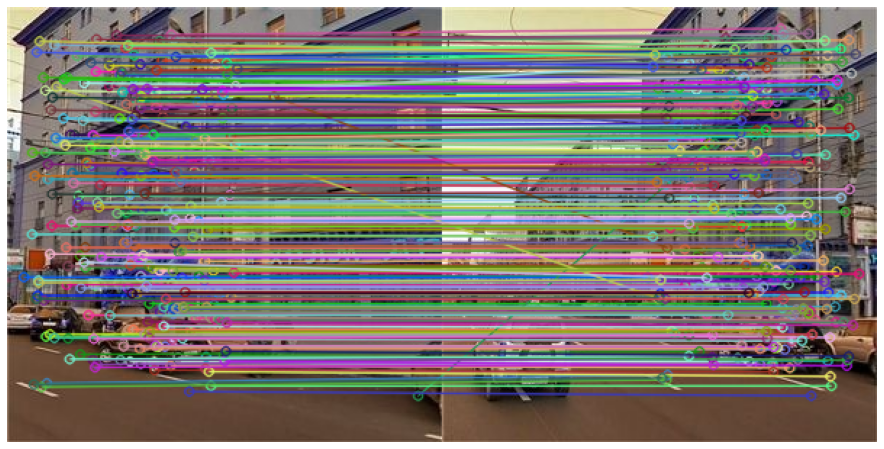

In [14]:
plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.axis('off')
plt.show()

### Retrieval

In [12]:
import heapq

In [13]:
minHessian = 400
surf = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)

In [14]:
%%time
PATH_IMGS = PATH_PROJECT / '.data/imat2011/result_jpg_300/'

index = []
for i, path in enumerate(PATH_IMGS.glob('[0-9][0-9]_*.jpg')):
    try:
        img = cv.imread(str(path))
        kps, dsrc = surf.detectAndCompute(img, None)
        index.append((dsrc, img))
    except:
        pass

CPU times: user 3min 3s, sys: 2min 1s, total: 5min 5s
Wall time: 5.75 s


In [15]:
len(index)

450

In [16]:
def get_closests(index, img, k=9):
    if len(index) < k:
        return index
    
    dscr, _ = img
    closests = []
    
    for i, (dscr_other, _) in enumerate(index[:k]):
        knn_matches = matcher.knnMatch(dscr, dscr_other, 2)
        ratio_thresh = 0.7
        good_matches = []
        for m, n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        closests.append((len(good_matches), i))
    
    heapq.heapify(closests)    

    for i, (dscr_other, _) in enumerate(index):
        knn_matches = matcher.knnMatch(dscr, dscr_other, 2)
        ratio_thresh = 0.7
        good_matches = []
        for m, n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)

        d = len(good_matches)
        
        if d > closests[0][0]:
            heapq.heapreplace(closests, (d, i))
    return closests

In [21]:
%%time
closests = get_closests(index, index[65], k=9)

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.36 s


In [22]:
closests.sort(reverse=True)

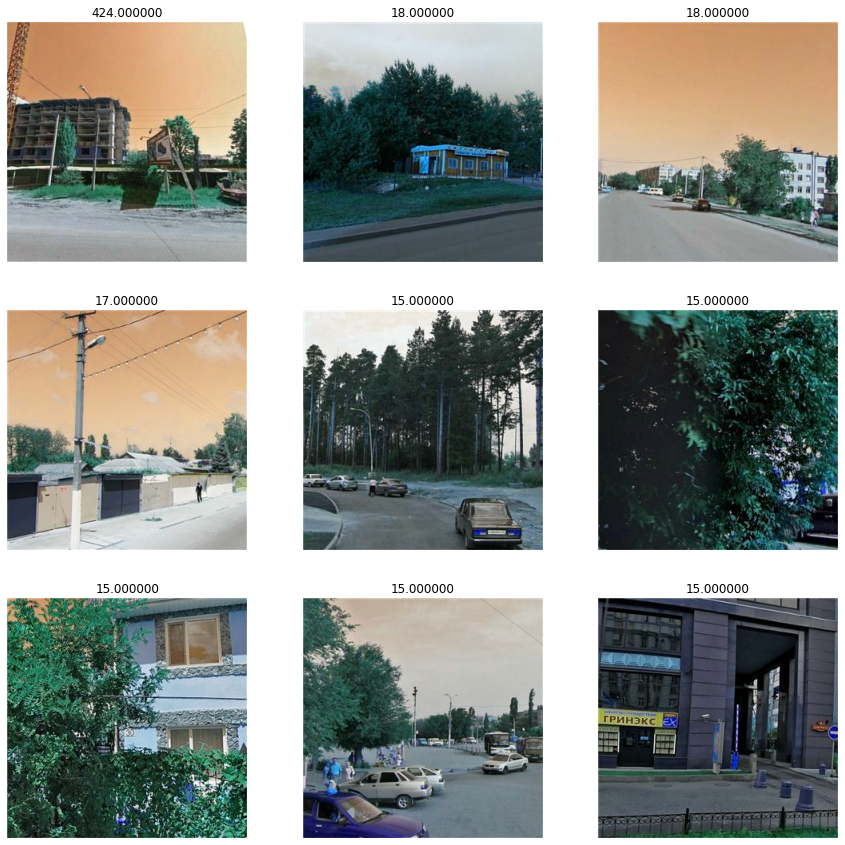

In [23]:
plt.figure(figsize=(15, 15))
for i, (d, _id) in enumerate(closests, 1):
    ax = plt.subplot(3, 3, i)
    plt.imshow(index[_id][1])
    plt.title("%f" % d)
    plt.axis("off")

In [103]:
# kp_desc = [(detector.detectAndCompute(img, None)) for img in imgs]

In [101]:
# matches = np.empty((5,5))
# for i, (kp1, desc1) in enumerate(kp_desc):
#     for j, (kp2, desc2) in enumerate(kp_desc):        
#         knn_matches = matcher.knnMatch(desc1, desc2, 2)
#         #-- Filter matches using the Lowe's ratio test
#         ratio_thresh = 0.7
#         good_matches = [m for m, n in knn_matches if m.distance < ratio_thresh * n.distance]
#         matches[i][j] = len(good_matches)

In [102]:
# matches

In [13]:
## sift-based retrieval

In [104]:
# sift = cv.xfeatures2d_SIFT.create()

In [105]:
# kp_desc = [(sift.detectAndCompute(img, None)) for img in imgs]

In [106]:
# # Step 2: Matching SIFT descriptors vectors with a FLANN based matcher
# (_, d1), (_, d2) = kp_desc[0], kp_desc[1]
# matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
# knn_matches = matcher.knnMatch(d1, d2, 2)
# #-- Filter matches using the Lowe's ratio test
# ratio_thresh = 0.7
# good_matches = []
# for m, n in knn_matches:
#     if m.distance < ratio_thresh * n.distance:
#         good_matches.append(m)

# #-- Draw matches
# img_matches = np.empty(
#     (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), 
#     dtype=np.uint8)

# _ = cv.drawMatches(
#     img1, keypoints1,
#     img2, keypoints2,
#     good_matches,
#     img_matches,
#     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [ ]:
# # FLANN parameters
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)   # or pass empty dictionary
# flann = cv.FlannBasedMatcher(index_params,search_params)
# matches = flann.knnMatch(des1,des2,k=2)
# # Need to draw only good matches, so create a mask
# matchesMask = [[0,0] for i in range(len(matches))]
# # ratio test as per Lowe's paper
# for i,(m,n) in enumerate(matches):
#     if m.distance < 0.7*n.distance:
#         matchesMask[i]=[1,0]
# draw_params = dict(matchColor = (0,255,0),
#                    singlePointColor = (255,0,0),
#                    matchesMask = matchesMask,
#                    flags = cv.DrawMatchesFlags_DEFAULT)
# img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
# plt.imshow(img3,),plt.show()
